# Chapter 5: VAR models

In [8]:
suppressMessages(library(tidyverse)) # Readr, ggplot, dplyr, ...
suppressMessages(library(gridExtra)) # Arrangning ggplots
suppressMessages(library(readxl))    # Loading excel
suppressMessages(library(repr))      # Resizing the plots in jupyter
suppressMessages(library(rugarch))   # For ARCH and GARCH models
suppressMessages(library(dynlm))     # Lagged linear models
suppressMessages(library(urca))      # Dick Fuller test
suppressMessages(library(car))       # Linear hyphothesis testing
suppressMessages(library(tseries))   # Adf-test
suppressMessages(library(vars))      # VAR models
suppressMessages(library(zoo))       # Convert quarters to date
suppressMessages(library(forecast))  # Help in plotting TS
suppressMessages(library(fGarch))    # The library Lasse uses to do GARCH
suppressMessages(library(expm))      # Matrix calculations 


options(warn=-1) # Carefull this disables all warnings
options(repr.plot.width=9, repr.plot.height=2.5)

setwd("C:/Users/larsn/Documents/GitHub/Applied-Econometric-Time-Series-WE")

# Exercise 1: Intervention analysis
Consider exercise 2a and 2b in chapter 5. Moreover, to get some feeling ofwhat the apparent shift in 1997Q4 does to the slope parameter, consider first a naive AR(1) without any dummy and compare this with an AR(1) including the dummy

In [4]:
terror <- read_delim("~/GitHub/Applied-Econometric-Time-Series-WE/Data/Terrorism.csv", 
                        ";", escape_double = FALSE, col_types = cols(ENTRY = col_character()), 
                        trim_ws = TRUE)
terror$date <- as.Date(as.yearqtr(terror$ENTRY, format = "%Y-%q"))

tt <- gather(terror, variable, value, -date, -ENTRY)

p <- ggplot(tt, aes(date, value, linetype=variable)) + 
  geom_line() + 
  labs(title="Terrorism")
print(p)

ERROR: Error in png(tf, width, height, "in", pointsize, bg, res, antialias = antialias): kan ikke starte png()-enhed


plot without title

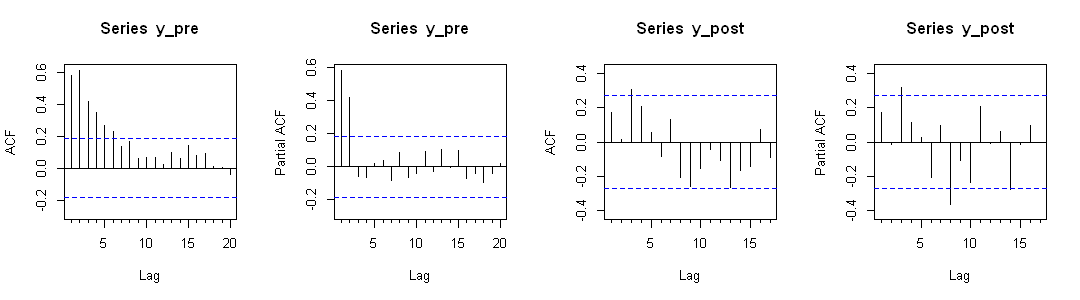

In [195]:
terror_pre_97  <- subset(terror, date < as.Date("1998-01-01"))
terror_post_97 <- subset(terror, date >= as.Date("1998-01-01"))

y_pre <- terror_pre_97$Transnational
y_post <- terror_post_97$Transnational

par(mfrow=c(1,4))
Acf(y_pre)
Pacf(y_pre)
Acf(y_post)
Pacf(y_post)

It looks like an AR(2) model would fit the pre period pretty well, we check with auto.arima

In [196]:
auto.arima(y_pre)
auto.arima(y_post)

Series: y_pre 
ARIMA(2,1,1) 

Coefficients:
         ar1     ar2      ma1
      0.3226  0.4189  -0.9663
s.e.  0.0976  0.0944   0.0428

sigma^2 estimated as 100.2:  log likelihood=-412.18
AIC=832.36   AICc=832.73   BIC=843.19

Series: y_post 
ARIMA(1,0,1) with non-zero mean 

Coefficients:
          ar1     ma1     mean
      -0.6286  0.9336  14.3899
s.e.   0.1335  0.0639   0.9220

sigma^2 estimated as 33.4:  log likelihood=-163.86
AIC=335.72   AICc=336.57   BIC=343.52

In [197]:
terror$z <- ifelse(terror$date >= as.Date("1998-01-01"), 1,0)

m1 <- lm(terror$Transnational ~ terror$z)
m1

m2 <- arima(terror$Transnational, order=c(2,0,0), xreg=terror$z, method="CSS")
m2

terror$z <- as.ts(terror$z)
terror$Transnational <- as.ts(terror$Transnational)

m3 <- dynlm(terror$Transnational ~ L(terror$Transnational,1) + L(terror$Transnational,2) + terror$z)
m3


Call:
lm(formula = terror$Transnational ~ terror$z)

Coefficients:
(Intercept)     terror$z  
      29.09       -14.70  



Call:
arima(x = terror$Transnational, order = c(2, 0, 0), xreg = terror$z, method = "CSS")

Coefficients:
         ar1     ar2  intercept  terror$z
      0.3247  0.3867    30.2980  -16.1052
s.e.  0.0720  0.0713     2.8463    4.4009

sigma^2 estimated as 78.32:  part log likelihood = -590.29


Time series regression with "ts" data:
Start = 3, End = 164

Call:
dynlm(formula = terror$Transnational ~ L(terror$Transnational, 
    1) + L(terror$Transnational, 2) + terror$z)

Coefficients:
               (Intercept)  L(terror$Transnational, 1)  
                    9.1018                      0.3231  
L(terror$Transnational, 2)                    terror$z  
                    0.3740                     -5.0028  


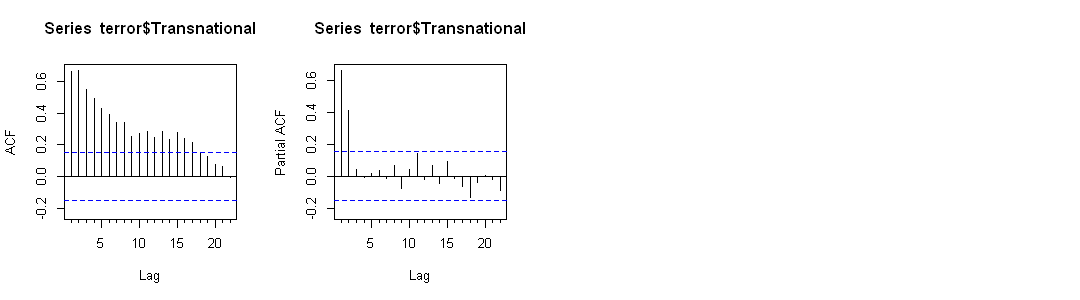

In [261]:
par(mfrow=c(1,4))
Acf(terror$Transnational)
Pacf(terror$Transnational)

In [199]:
m4 <- arima(terror$Transnational, order=c(1,0,1), xreg=terror$z)
m4


Call:
arima(x = terror$Transnational, order = c(1, 0, 1), xreg = terror$z)

Coefficients:
         ar1      ma1  intercept  terror$z
      0.8782  -0.4828    28.3536  -14.6235
s.e.  0.0527   0.0862     3.3512    5.0096

sigma^2 estimated as 82.14:  log likelihood = -594.51,  aic = 1199.02

In [200]:
AIC(m1)
AIC(m2)
AIC(m3)
AIC(m4)

[1] 1275.323

numeric(0)

[1] 1179.046

[1] 1199.023

## The effect of the dummy

In [201]:
dynlm(terror$Transnational ~ L(terror$Transnational))
dynlm(terror$Transnational ~ L(terror$Transnational) + terror$z)


Time series regression with "ts" data:
Start = 2, End = 164

Call:
dynlm(formula = terror$Transnational ~ L(terror$Transnational))

Coefficients:
            (Intercept)  L(terror$Transnational)  
                 8.3371                   0.6621  



Time series regression with "ts" data:
Start = 2, End = 164

Call:
dynlm(formula = terror$Transnational ~ L(terror$Transnational) + 
    terror$z)

Coefficients:
            (Intercept)  L(terror$Transnational)                 terror$z  
                13.5617                   0.5401                  -7.0299  


## Impulse Response Functions to terrorism

In [202]:
var_terror <- terror[,c(2,3)]
m <-VAR(var_terror, p=3, type="const")

In [203]:
data <- irf(m, nsteps = 12, n.ahead=20)

variables <- data$irf %>% names

ir <- lapply(1:length(variables), function(e){
    data_to_plot <- data.frame(data %>% `$`(irf) %>% `[[`(variables[e])) %>%
      mutate("t" = 1:NROW(.)) %>%
      gather(.,Variable, Value, -t)

    upper_ci <- data.frame(data %>% `$`(Upper) %>% `[[`(variables[e])) %>%
      mutate("t" = 1:NROW(.)) %>%
      gather(.,Variable, Upper, -t)

    lower_ci <- data.frame(data %>% `$`(Lower) %>% `[[`(variables[e]) ) %>%
      mutate("t" = 1:NROW(.)) %>%
      gather(.,Variable, Lower, -t)

    res <- inner_join(data_to_plot, upper_ci, c("t","Variable")) %>%
           inner_join(.,lower_ci, c("t","Variable")) %>%
           mutate(impulse = paste("Shock to", variables[e])) 
}) %>% bind_rows

head(ir)

t,Variable,Value,Upper,Lower,impulse
1,Domestic,44.96057,51.56412,36.52391,Shock to Domestic
2,Domestic,26.41709,32.43788,18.89505,Shock to Domestic
3,Domestic,18.61137,25.87050,10.60560,Shock to Domestic
4,Domestic,24.09297,29.27313,15.43986,Shock to Domestic
5,Domestic,22.07804,26.58292,14.02199,Shock to Domestic
6,Domestic,19.62772,25.10766,10.93725,Shock to Domestic


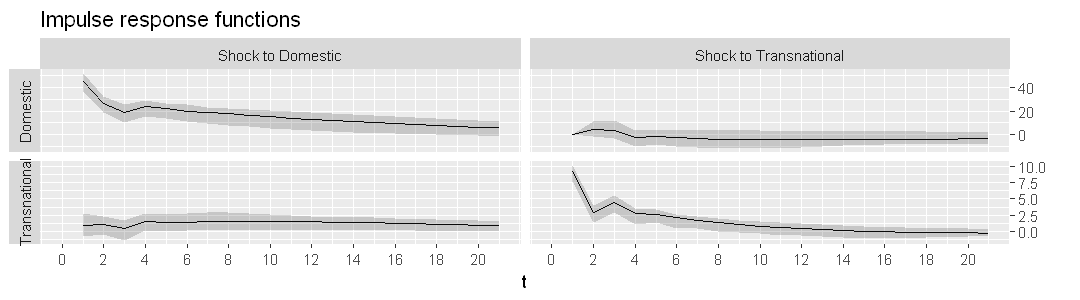

In [204]:
p <- ggplot(ir, aes(x = t, y = Value, group = Variable))  +
  geom_line() +
  geom_ribbon(aes(x=t, ymax=Upper, ymin=Lower), alpha=0.2) +
  scale_x_continuous(limits = c(0,21), breaks = seq(0,20,2)) +
  scale_y_continuous("", position="right") +
  facet_grid(Variable ~ impulse, scales="free", switch="y") + 
  labs(title="Impulse response functions")
print(p)

# Exercise 2: Consider the following two-dimensional VAR(1) 
where $y_t$ and $u_t$ is a vector

$$y_t = 
\begin{bmatrix} 0.02 \\ 0.03 \end{bmatrix}
+
\begin{bmatrix} 0.5 & 0.1 \\ 0.4 & 0.5 \end{bmatrix}
y_{t-1}+
\begin{bmatrix} 0 & 0 \\ 0.25 & 0 \end{bmatrix}
y_{t-2} + u_t$$


Specify each element of yt as a single equation proces. Show that the VAR is stationary. Tip: write up the companion matrix. The eigen-
values are complex; see the handout on the unit circle for a graphical illustration or the use of the modulus.

$$a_t = 0.02 + 0.5a_{t-1} + 0.1b_{t-1} + ua_t $$

$$b_t = 0.03 + 0.4a_{t-1} + 0.5b_{t-1} + 0.25a_{t-2} + ua_t $$

\begin{bmatrix} 
0.5 & 0.1 & 0 & 0 \\ 
0.4 & 0.5 & 0.25 & 0 \\
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
\end{bmatrix}

In [205]:
companion <- t(matrix(c(0.5,0.1,0,0,0.4,0.5,0.25,0,1,0,0,0,0,1,0,0), nrow=4))
companion

0.5,0.1,0.00,0
0.4,0.5,0.25,0
1.0,0.0,0.00,0
0.0,1.0,0.00,0


In [206]:
#eigen(companion)$values
round(Mod(eigen(companion)$values),3)

[1] 0.769 0.180 0.180 0.000

# Exercise 3: Estimate a trivariate VAR(2) using OLS

In [207]:
germany <- read_excel("Data/GermanyCYI.xls")
head(germany)

I <- germany$I
Y <- germany$Y
C <- germany$C

I,Y,C
180,451,415
179,465,421
185,485,434
192,493,448
211,509,459
202,520,458


## 1. Plot the data
The data looks non-stationary, right? Test each individual series using a Dickey-Fuller test

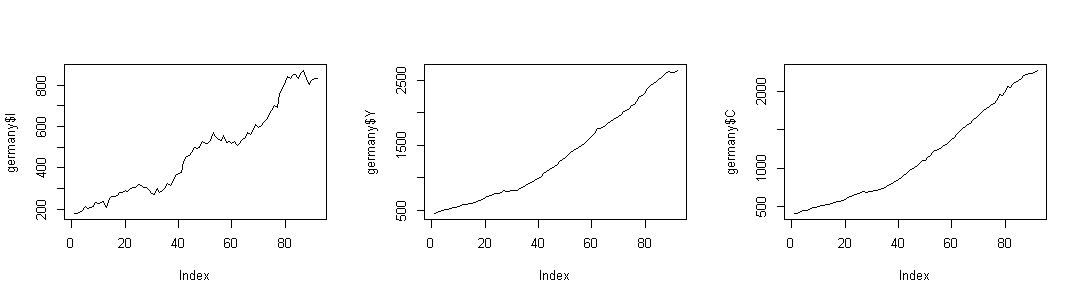

In [208]:
par(mfrow=c(1,3))

plot(germany$I, type = "l")
plot(germany$Y, type = "l")
plot(germany$C, type = "l")

In [209]:
adf.test(germany$I)
adf.test(germany$Y)
adf.test(germany$C)


	Augmented Dickey-Fuller Test

data:  germany$I
Dickey-Fuller = -3.1875, Lag order = 4, p-value = 0.09471
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  germany$Y
Dickey-Fuller = -2.2936, Lag order = 4, p-value = 0.4552
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  germany$C
Dickey-Fuller = -2.3345, Lag order = 4, p-value = 0.4384
alternative hypothesis: stationary


## Quick manual ADF test

1. bestemmelse af lag længde - estimere stor model med mange lags og fjerne indtil sidste er signifikant

In [210]:
I <- as.ts(I)
dI <- diff(I)
trnd <- seq_along(dI)
reg <- dynlm(dI ~ trnd + L(I) + L(dI) + L(dI,2) + L(dI,3) + L(dI,4))
summary(reg)


Time series regression with "ts" data:
Start = 6, End = 92

Call:
dynlm(formula = dI ~ trnd + L(I) + L(dI) + L(dI, 2) + L(dI, 3) + 
    L(dI, 4))

Residuals:
    Min      1Q  Median      3Q     Max 
-35.474  -9.930   0.634   9.513  47.519 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 14.86157    5.55186   2.677  0.00901 ** 
trnd         0.99376    0.31124   3.193  0.00201 ** 
L(I)        -0.12493    0.03919  -3.188  0.00205 ** 
L(dI)       -0.04746    0.10105  -0.470  0.63988    
L(dI, 2)     0.03870    0.09995   0.387  0.69962    
L(dI, 3)     0.25974    0.09990   2.600  0.01110 *  
L(dI, 4)     0.38200    0.10509   3.635  0.00049 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 17.03 on 80 degrees of freedom
Multiple R-squared:  0.234,	Adjusted R-squared:  0.1765 
F-statistic: 4.073 on 6 and 80 DF,  p-value: 0.001294


tallet på -3.188 er ikke numerisk stort nok til at vi kan afvise unit root, vi går videre:

In [211]:
linearHypothesis(reg,
                 c("L(I) = 0", "trnd = 0"),
                 test="F")
linearHypothesis(reg,
                 c("L(I) = 0", "(Intercept) = 0", "trnd = 0"),
                 test="F")

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
82,26182.24,NA,NA,NA,NA
80,23189.49,2,2992.747,5.162249,0.00778713


Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
83,27074.85,NA,NA,NA,NA
80,23189.49,3,3885.359,4.467955,0.005938948


Det virker ikke til at vi må fjerne trend

## 2. Calculate log diferences of the data
Plot the data and verify stationarity of one of the now transformed series

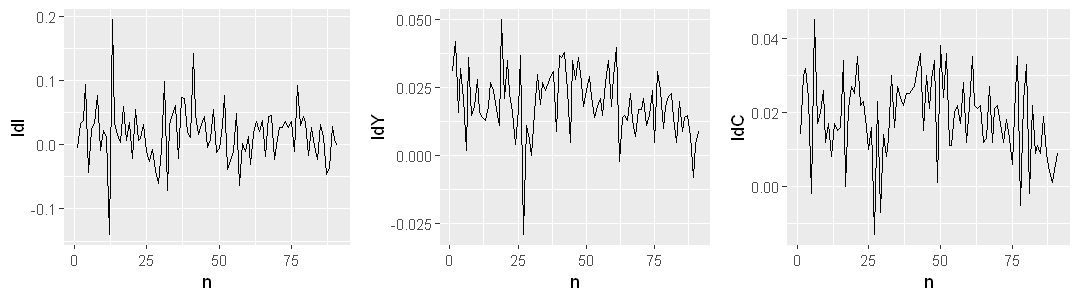

In [257]:
ldI <- round(diff(log(germany$I)),3)
ldY <- round(diff(log(germany$Y)),3)
ldC <- round(diff(log(germany$C)),3)

n <- c(1:length(ldC))
a <- qplot(n, ldI, geom = "line")
b <- qplot(n, ldY, geom = "line")
c <- qplot(n, ldC, geom = "line")
grid.arrange(a,b,c, nrow=1)

## 3. Make a subset of the data
In particular, extract enough data so that you can construct Y below with 10 observations of the three variables. Then consider a VAR(2) where the left-hand-side vector of three variables (y1; y2; y3) consist of 10 observations only. Obviously, the right-hand-side matrix of explanatory variables also contain 10 observations. Estimate:

$$\underset{m\times mp}{\mathrm{\hat{\Phi}}}   = \underset{m\times T}{\mathrm{Y}} Z^T(\underset{mp\times T}{\mathrm{Z}}Z^T)^{-1} $$

where m = 3; p = 2; T = 10: The purpose of this exercise to practise OLS and to organize data and lags of data appropriately. You could consider to estimate this model using your favourite software.

In [213]:
a <- matrix(c(0.5,0.5,0.5,0.5), nrow=2)
a
eigen(a)

0.5,0.5
0.5,0.5


eigen() decomposition
$values
[1] 1 0

$vectors
          [,1]       [,2]
[1,] 0.7071068 -0.7071068
[2,] 0.7071068  0.7071068


In [214]:
constant <- c(rep(1,10))

Y <- t(cbind(ldI[3:12], ldY[3:12], ldC[3:12]))

Y1 <- cbind(ldI[2:11], ldY[2:11], ldC[2:11])

Y2 <- cbind(ldI[1:10], ldY[1:10], ldC[1:10])

Z <- t(cbind(constant, Y1, Y2))

t(Z)

constant,,,,,,
1,0.033,0.042,0.030,-0.006,0.031,0.014
1,0.037,0.016,0.032,0.033,0.042,0.030
1,0.094,0.032,0.024,0.037,0.016,0.032
1,-0.044,0.021,-0.002,0.094,0.032,0.024
1,0.024,0.002,0.045,-0.044,0.021,-0.002
1,0.033,0.036,0.017,0.024,0.002,0.045
1,0.076,0.015,0.020,0.033,0.036,0.017
1,-0.009,0.018,0.026,0.076,0.015,0.020
1,0.022,0.028,0.012,-0.009,0.018,0.026
1,0.013,0.016,0.017,0.022,0.028,0.012


In [215]:
coef <- round((Y %*% t(Z) %*% solve(Z %*% t(Z))),3)
coef

constant,,,,,,
-0.198,-1.145,0.148,4.061,-0.427,1.859,5.196
0.005,-0.011,-0.336,0.771,0.011,-0.032,0.271
0.003,-0.206,0.270,-0.118,-0.073,0.690,0.187


Calculate the eigenvalues and the roots.

In [216]:
coef1 <- coef[,-1]

idm <- diag(3)
zm <- matrix(rep(0,9), nrow=3)
comp <- cbind(idm, zm)
companion <- rbind(coef1, comp)

companion

#round(eigen(companion)$values,3)
round(Mod(eigen(companion)$values),3)

,,,,,
-1.145,0.148,4.061,-0.427,1.859,5.196
-0.011,-0.336,0.771,0.011,-0.032,0.271
-0.206,0.270,-0.118,-0.073,0.690,0.187
1.000,0.000,0.000,0.000,0.000,0.000
0.000,1.000,0.000,0.000,0.000,0.000
0.000,0.000,1.000,0.000,0.000,0.000


[1] 0.837 0.837 0.803 0.559 0.559 0.394

## Estimate the model for the period 1960 to 1978. Verify the solution by pre- programmed standard software.
Calculate the magnitude of the eigenvalues of the companion matrix. Is the system stationary, i.e. are the roots inside the unit circle?

In [217]:
length(germany$Y)

[1] 92

In [218]:
end <- 91 # 75 answers the question
end1 <- end - 1
end2 <- end - 2

constant <- c(rep(1,end2))

Y <- t(cbind(ldI[3:end], ldY[3:end], ldC[3:end]))

Y1 <- cbind(ldI[2:end1], ldY[2:end1], ldC[2:end1])

Y2 <- cbind(ldI[1:end2], ldY[1:end2], ldC[1:end2])

Z <- t(cbind(constant, Y1, Y2))

coef <- Y %*% t(Z) %*% solve(Z %*% t(Z))

coef1 <- coef[,-1]

idm <- diag(3)
zm <- matrix(rep(0,9), nrow=3)
comp <- cbind(idm, zm)
companion <- rbind(coef1, comp)

#companion

#round(eigen(companion)$values,3)
round(Mod(eigen(companion)$values),3)
coef

[1] 0.600 0.556 0.556 0.488 0.488 0.380

constant,,,,,,
-0.009589597,-0.271725608,0.3389137,0.6506495,-0.13276114,0.19399627,0.56532400
0.012576976,0.043831334,-0.1269562,0.3104125,0.06100524,0.01599373,0.05239911
0.012385302,0.003401803,0.2843616,-0.2763355,0.04992158,0.36402601,-0.11520716


In [219]:
# reduced form 
ldgermany <- data.frame(ldI, ldY, ldC)

m <-VAR(ldgermany, p=2, type="const")
m
roots(m, modulus = TRUE)


VAR Estimation Results:

Estimated coefficients for equation ldI: 
Call:
ldI = ldI.l1 + ldY.l1 + ldC.l1 + ldI.l2 + ldY.l2 + ldC.l2 + const 

      ldI.l1       ldY.l1       ldC.l1       ldI.l2       ldY.l2       ldC.l2 
-0.271725608  0.338913659  0.650649493 -0.132761142  0.193996267  0.565324000 
       const 
-0.009589597 


Estimated coefficients for equation ldY: 
Call:
ldY = ldI.l1 + ldY.l1 + ldC.l1 + ldI.l2 + ldY.l2 + ldC.l2 + const 

     ldI.l1      ldY.l1      ldC.l1      ldI.l2      ldY.l2      ldC.l2 
 0.04383133 -0.12695621  0.31041255  0.06100524  0.01599373  0.05239911 
      const 
 0.01257698 


Estimated coefficients for equation ldC: 
Call:
ldC = ldI.l1 + ldY.l1 + ldC.l1 + ldI.l2 + ldY.l2 + ldC.l2 + const 

      ldI.l1       ldY.l1       ldC.l1       ldI.l2       ldY.l2       ldC.l2 
 0.003401803  0.284361552 -0.276335498  0.049921579  0.364026005 -0.115207165 
       const 
 0.012385302 



[1] 0.5995859 0.5558930 0.5558930 0.4875824 0.4875824 0.3802857

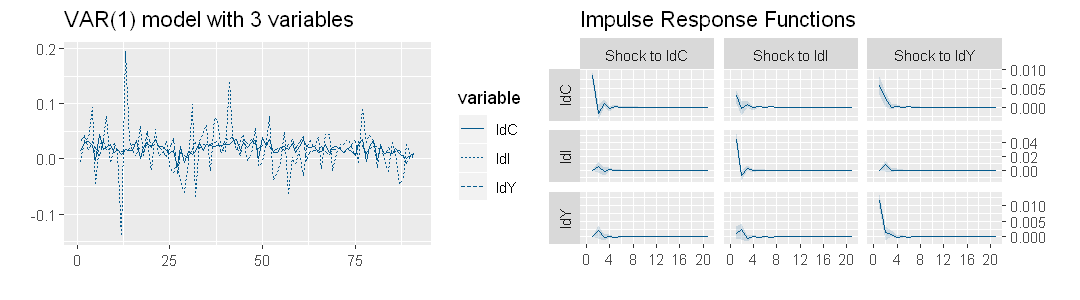

In [229]:
irf_lars <- function(x) {
    m <- VAR(x, p = 1, type = "const")
    hej <- ncol(x)
    chart_title <- substitute(paste("VAR(1) model with ", hej," variables"))
psim <- as.data.frame(x)
psim$n <- c(1:91)
psim <- gather(psim, variable, value, -n)

p1 <- ggplot(psim, aes(n, value, linetype=variable)) + 
 geom_line(color="#045a8d") + 
 labs(title=chart_title, x="", y="")

data <- irf(m, nsteps = 12, n.ahead=20)
variables <- data$irf %>% names

ir <- lapply(1:length(variables), function(e){
    data_to_plot <- data.frame(data %>% `$`(irf) %>% `[[`(variables[e])) %>%
      mutate("t" = 1:NROW(.)) %>%
      gather(.,Variable, Value, -t)

    upper_ci <- data.frame(data %>% `$`(Upper) %>% `[[`(variables[e])) %>%
      mutate("t" = 1:NROW(.)) %>%
      gather(.,Variable, Upper, -t)

    lower_ci <- data.frame(data %>% `$`(Lower) %>% `[[`(variables[e]) ) %>%
      mutate("t" = 1:NROW(.)) %>%
      gather(.,Variable, Lower, -t)

    res <- inner_join(data_to_plot, upper_ci, c("t","Variable")) %>%
           inner_join(.,lower_ci, c("t","Variable")) %>%
           mutate(impulse = paste("Shock to", variables[e])) 
}) %>% bind_rows

p2 <- ggplot(ir, aes(x = t, y = Value, group = Variable))  +
  geom_line(color="#045a8d") +
  geom_ribbon(aes(x=t, ymax=Upper, ymin=Lower), alpha=0.15, fill="#045a8d") +
  scale_x_continuous(limits = c(0,21), breaks = seq(0,20,4)) +
  scale_y_continuous("", position="right") +
  labs(title="Impulse Response Functions", x="") +
  facet_grid(Variable ~ impulse, scales="free", switch="y")

grid.arrange(p1, p2, nrow=1)
}

irf_lars(ldgermany)

# Exercise 4: A simple exercise that shows the identifation problem
Consider the following two SVARs and show that they both lead to the same reduced
form VAR. The structural SVAR is

$$
\begin{bmatrix} 1 & 0 \\ 1 & 1 \end{bmatrix}
\begin{bmatrix} y_{1t} \\ y_{2t} \end{bmatrix}
=
\begin{bmatrix} 0.5 & -1 \\ 0.5 & -1.5 \end{bmatrix}
\begin{bmatrix} y_{1t} \\ y_{2t} \end{bmatrix}
+
\begin{bmatrix} u_{1t} \\ u_{2t} \end{bmatrix}
\qquad \qquad
\Sigma_u = E
\begin{bmatrix} u_{1t} u_{1t}^T \end{bmatrix}
=
\begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}
$$

$$
\begin{bmatrix} 1 & 0.5 \\ 0 & 1 \end{bmatrix}
\begin{bmatrix} y_{1t} \\ y_{2t} \end{bmatrix}
=
\begin{bmatrix} 0.5 & -1.25 \\ 0 & -0.5 \end{bmatrix}
\begin{bmatrix} y_{1t} \\ y_{2t} \end{bmatrix}
+
\begin{bmatrix} u_{1t} \\ u_{2t} \end{bmatrix}
\qquad \qquad
\Sigma_u = E
\begin{bmatrix} u_{1t} u_{1t}^T \end{bmatrix}
=
\begin{bmatrix} 0.5 & 0 \\ 0 & 2 \end{bmatrix}
$$

In [221]:
b01 <- matrix(c(1,0,1,1), nrow=2, byrow=T)
b02 <- matrix(c(1,0.5,0,1), nrow=2, byrow=T)
A1 <- matrix(c(0.5,-1,0.5,-1.5), nrow=2, byrow=T)
A2 <- matrix(c(0.5,-1.25,0,-0.5), nrow=2, byrow=T)
S1 <- matrix(c(1,0,0,1), nrow=2, byrow=T)
S2 <- matrix(c(0.5,0,0,2), nrow=2, byrow=T)

a <- solve(b01) %*% A1
b <- solve(b02) %*% A2
c <- solve(b01) %*% S1 %*% t(solve(b01)) 
d <- solve(b02) %*% S2 %*% t(solve(b02)) 
cbind(a,b,c,d)

0.5,-1.0,0.5,-1.0,1,-1,1,-1
0.0,-0.5,0.0,-0.5,-1,2,-1,2


So this means that the operation of moving the $b_0$ matrix is similar for the two equations, here the first sVAR is used as an example:

$$
\begin{bmatrix} y_{1t} \\ y_{2t} \end{bmatrix}
=
\begin{bmatrix} 1 & 0 \\ 1 & 1 \end{bmatrix}^{-1}
\begin{bmatrix} 0.5 & -1 \\ 0.5 & -1.5 \end{bmatrix}
\begin{bmatrix} y_{1t} \\ y_{2t} \end{bmatrix}
+
\begin{bmatrix} 1 & 0 \\ 1 & 1 \end{bmatrix}^{-1}
\begin{bmatrix} u_{1t} \\ u_{2t} \end{bmatrix}
\qquad \qquad
\Sigma_{\epsilon}
=
\begin{bmatrix} 1 & 0 \\ 1 & 1 \end{bmatrix}^{-1}
\begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}
\begin{bmatrix} 1 & 0 \\ 1 & 1 \end{bmatrix}^{-1^T}
$$

And this means that the common reduced form VAR for the two sVAR models is the following:

$$
\begin{bmatrix} y_{1t} \\ y_{2t} \end{bmatrix}
=
\begin{bmatrix} 0.5 & -1 \\ 0 & -0.5 \end{bmatrix}
\begin{bmatrix} y_{1t} \\ y_{2t} \end{bmatrix}
+
\begin{bmatrix} 1 & 0 \\ 1 & 1 \end{bmatrix}^{-1}
\begin{bmatrix} u_{1t} \\ u_{2t} \end{bmatrix}
\qquad \qquad
\Sigma_{\epsilon}
=
\begin{bmatrix} 1 & -1 \\ -1 & 2 \end{bmatrix}
$$

Can you recover either the first SVAR og the second SVAR from the reduced form VAR? Why og why not?

??

# Exercise 5: VAR(1), VMA(1), SVMA(1), identifcation and impulse responses
This exercise is a combined analytical and small-scale quantitative exercise. The purpose is to become more familiar with the simplest possible VAR model, the corre- sponding SVAR and how to identify the parameters in the SVAR from the reduced form variance-covariance matrix. You are given the following reduced form VAR estimates from a VAR(1)

$$
\begin{bmatrix} y_{1t} \\ y_{2t} \end{bmatrix}
=
\begin{bmatrix} 0 \\ 0 \end{bmatrix}
+
\begin{bmatrix} 0.7 & 0.2 \\ 0.2 & 0.7 \end{bmatrix}
\begin{bmatrix} y_{1,t-1} \\ y_{1,t-1} \end{bmatrix}
+
\begin{bmatrix} \varepsilon_{1t} \\ \varepsilon_{2t} \end{bmatrix}
\qquad \qquad
\Sigma_{\epsilon}
=
\begin{bmatrix} 0.5 & 0.4 \\ 0.4 & 0.5 \end{bmatrix}
$$

and the following SVAR

$$
\begin{bmatrix} 1 & b_{0,12} \\ b_{0,21} & 1 \end{bmatrix}
\begin{bmatrix} y_{1t} \\ y_{2t} \end{bmatrix}
=
\begin{bmatrix} 0 \\ 0 \end{bmatrix}
+
\begin{bmatrix} b_{1,11} & b_{1,12} \\ b_{1,21} & b_{1,22} \end{bmatrix}
\begin{bmatrix} y_{1,t-1} \\ y_{1,t-1} \end{bmatrix}
+
\begin{bmatrix} \mu_{1,t} \\ \mu_{2,t} \end{bmatrix}
\qquad \qquad
\Sigma_{\mu}
=
\begin{bmatrix} \sigma^2_{1\mu} & 0 \\ 0 & \sigma^2_{2\mu} \end{bmatrix}
$$

### 5.1: What is the implied correlation between $\varepsilon_{1t}$ and $\varepsilon_{2t}$ calculated from $\Sigma_\varepsilon$

0.8

In [222]:
ma <- matrix(c(0.5,0.4,0.4,0.5), byrow=T, nrow=2)
cov2cor(ma)

1.0,0.8
0.8,1.0


### 5.2 Explained theoretically, can you estimate the SVAR by OLS? If not, why?

No because one condition of OLS is that the variables are not correlated with the residual, and if the equation is estimated by OLS both the parametres and the residual will be influenced by the simultaneous effect of $b_{0,12}$ og $b_{0,21}$

### 5.3 Explain how to identify the SVAR parameters. Hint: identification problem.

You use the $b_0$ matrix and multiplies it with the right side of the equation (inversed), and then use a cholesky decomposition to identify the parametres.

### 5.4 Given the SVAR variance-covariance matrix show that you cannot identify $\{ b_{0,12}, b_{0,21}, \sigma^2_{1u},\sigma^2_{2u} \}$ from the relation 
$$\Sigma_\varepsilon = B_0^{-1}\Sigma_\mu(B_0^{-1})^T$$

### 5.5 Now impose $b_{0,12} = 0$ Is this su¢cient to identify the parameters? If so, write down the solution of $\{ b_{0,12}, b_{0,21}, \sigma^2_{1u},\sigma^2_{2u} \}$ and $B_1$ and $\mu_t = B_0\varepsilon_t$

First i fill in what we know in this expression, and do the inverse and transpose operations

$$\Sigma_\varepsilon = B_0^{-1}\Sigma_\mu(B_0^{-1})^T$$

$$
\begin{bmatrix} 0.5 & 0.4 \\ 0.4 & 0.5 \end{bmatrix}
= 
\begin{bmatrix} 1 & 0 \\ -b_{0,21} & 1 \end{bmatrix}
\begin{bmatrix} \sigma^2_{1u} & 0 \\ 0 & \sigma^2_{2u} \end{bmatrix}
\begin{bmatrix} 1 & -b_{0,21} \\ 0 & 1 \end{bmatrix}
$$

By multiplying the right side matrices you get:

$$
\begin{bmatrix} 0.5 & 0.4 \\ 0.4 & 0.5 \end{bmatrix}
= 
\begin{bmatrix} \sigma^2_{1u} & -b_{0,21}\sigma^2_{1u} \\ -b_{0,21}\sigma^2_{1u} & b_{0,21}^2\sigma^2_{1u} + \sigma^2_{2u} \end{bmatrix}
$$

From er here we start solving, first it's clear that:

$$\sigma^2_{1u} = 0.5$$

because of this it means that:

$$ 0.4 = -b_{0,21} * 0.5$$
$$ b_{0,21} = -0.8$$

and then solve the last:

$$ 0.5 = -0.8^2*0.5+\sigma^2_{2u}$$
$$ \sigma^2_{2u} = 0.18 $$

Now we can find $B_1$ 
$$ B_1 = B_0^{-1} * A_1$$

$$ B_1 = 
\begin{bmatrix} 1 & 0 \\ -0.8 & 1 \end{bmatrix}^{-1}
\begin{bmatrix} 0.7 & 0.2 \\ 0.2 & 0.7 \end{bmatrix}
$$

$$ B_1 = \begin{bmatrix} 0.7 & 0.2 \\ 0.76 & 0.86 \end{bmatrix} $$

In [3]:
b0 <- matrix(c(1,0,-0.8,1), byrow=T, nrow=2)
a1 <- matrix(c(0.7,0.2,0.2,0.7), byrow=T, nrow=2)
solve(b0) %*% a1

0.70,0.20
0.76,0.86


In [4]:
chol(matrix(c(0.5,0.4,0.5,0.4), byrow=T, nrow=2))
solve(b0)

0.7071068,0.5656854
0.0000000,0.2828427


1.0,0
0.8,1


### 5.6 Calculate the VMA for i = 1, 2, ..., 5:

In [224]:
A <- matrix(c(0.7,0.2,0.2,0.7), byrow=T,nrow=2)

row <- data.frame(NA,NA,NA,NA)

for (i in 0:19) {
    row[i+1,] <- t(as.vector(A %^% i))
}

row$n <- 1:20
colnames(row) <- c("1. shock in y1 on y1", "2. shock in y2 on y1", "3. shock in y1 on y2", "4. shock in y2 on y2", "n")
df <- gather(row, variable, value, -n)

p1 <- ggplot(df, aes(n, value)) + 
geom_line() + 
facet_wrap(~variable) + 
labs(title="VMA solution")

head(row,4)

1. shock in y1 on y1,2. shock in y2 on y1,3. shock in y1 on y2,4. shock in y2 on y2,n
1.000,0.000,0.000,1.000,1
0.700,0.200,0.200,0.700,2
0.530,0.280,0.280,0.530,3
0.427,0.302,0.302,0.427,4


### 5.7 Calculate the SVMA for i = 1, 2, ..., 5. To calculate the impulse responses, we could continue and use $B_0^{-1}$ from above. However, why not practise the Cholesky decomposition of $\Sigma_\varepsilon$ Hence calculating the Cholesky decomposition, you should get:

$$ P = \begin{bmatrix} 0.7071 & 0 \\ 0.5657 & 0.4243 \end{bmatrix}$$

In [6]:
P <- (chol(matrix(c(0.5,0.4,0.4,0.5), byrow=T,nrow=2)))
P

0.7071068,0.5656854
0.0000000,0.4242641


Now i use the choleski factor to calculate the IRF

In [10]:
A <- matrix(c(0.7,0.2,0.2,0.7), byrow=T,nrow=2)


row <- data.frame(NA,NA,NA,NA)

for (i in 0:19) {
    row[i+1,] <- t(as.vector(P %*% (A %^% i)))
}

row$n <- 1:20
colnames(row) <- c("1. shock in y1 on y1",  "3. shock in y1 on y2", "2. shock in y2 on y1", "4. shock in y2 on y2", "n")
df <- gather(row, variable, value, -n)

p2 <- ggplot(df, aes(n, value)) + 
geom_line() + 
facet_wrap(~variable) + 
labs(title="SVMA P solution")

head(row,4)

1. shock in y1 on y1,3. shock in y1 on y2,2. shock in y2 on y1,4. shock in y2 on y2,n
0.7071068,0.00000000,0.5656854,0.4242641,1
0.6081118,0.08485281,0.5374012,0.2969848,2
0.5331585,0.11879394,0.4978032,0.2248600,3
0.4727716,0.12812775,0.4550939,0.1811608,4


But these can also be calculated by the $B_0$ we found earlier (it doesn't give the same results and i don't know why)

In [227]:
A <- matrix(c(0.7,0.2,0.2,0.7), byrow=T,nrow=2)
b <- matrix(c(1,0,-0.8,1), byrow=T,nrow=2)

row <- data.frame(NA,NA,NA,NA)

for (i in 0:19) {
    row[i+1,] <- t(as.vector(solve(b) %*% (A %^% i)))
}


row$n <- 1:20
colnames(row) <- c("1. shock in y1 on y1", "2. shock in y2 on y1", "3. shock in y1 on y2", "4. shock in y2 on y2", "n")
df <- gather(row, variable, value, -n)

p3 <- ggplot(df, aes(n, value)) + 
geom_line() + 
facet_wrap(~variable) + 
labs(title="SVMA B_0 solution")

head(row,4)

1. shock in y1 on y1,2. shock in y2 on y1,3. shock in y1 on y2,4. shock in y2 on y2,n
1.000,0.8000,0.000,1.0000,1
0.700,0.7600,0.200,0.8600,2
0.530,0.7040,0.280,0.7540,3
0.427,0.6436,0.302,0.6686,4


## Why different results from P and B_0 ?????

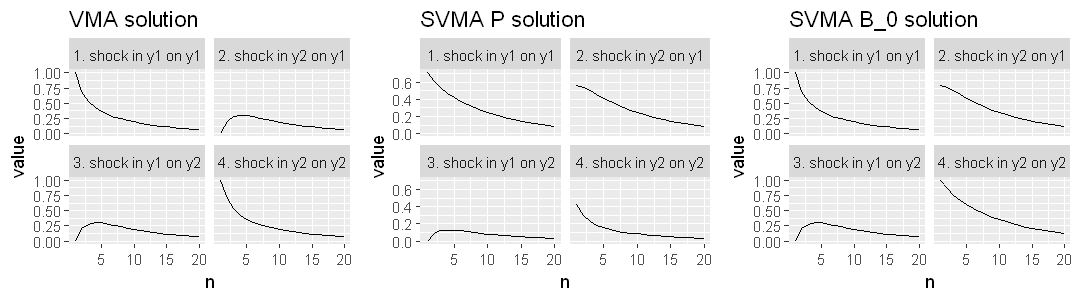

In [228]:
grid.arrange(p1,p2,p3, nrow=1)

# Exercise 6: Discussion and Overview

### 6.1 Propose situations where a VAR would be a good model choice. Why may univariate models be insu¢cient?

### 6.2 Describe the terms VAR(p), VMA, and SVMA

### 6.3 What is a lag operator and give an example of the use the lag operator

### 6.4 Describe the notion of "curse of dimensionality" and try to give an example

### 6.5 What is a Cholesky decomposition and how can we use it in VAR analyses?
What does causal ordering means. Give an example in terms of the use of Cholesky decomposition.

### 6.6 Based on Lutz Killians handbook chapter, Summarize the use of SVAR. What is the critique of using the Cholesky decomposition in structural VAR analyses?

# Exercise 7: Orthogonalized impulse response functions using the Cholesky decomposition
Consider again the data in the …rst exercise where you estimated ?b? for the some- m?mp what longer period 1960 to 1978. Now it is time to calculate orthogonalized impulse response function using the Cholesky decomposition.

### 7.1 The order of the variables in the VAR is important for the impulse responses; cf. the discussion in Kilian. Choose the order f?ln i;?ln y;?ln cg : Firstly, the estimated ?b? including the constant is

### 7.2 The estimated variance-covariance matrix of the reduced form VAR residuals

### 7.3 Calculate the orthogonalized impulse responses seen in ?0; ?1;

### 7.4 Compare with the following graphs. Interpret each graph and …nd the correspon- dance between each graph and ?1; ?2; ::::